In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt

# Behavioral Learning Experiment

In [2]:
dog_data = np.loadtxt('./behavioral.csv', delimiter=',', skiprows=2)

In [3]:
# number of dogs shocked in each trial
num_shocked_per_trial = sum(dog_data)
trials = list(range(1,26))
dogs_pd = pd.DataFrame(list(zip(trials, num_shocked_per_trial)), columns=['Trial', 'Number of Dogs Shocked'])

Text(0.5,1,'Number of Dogs Shocked vs Trial')

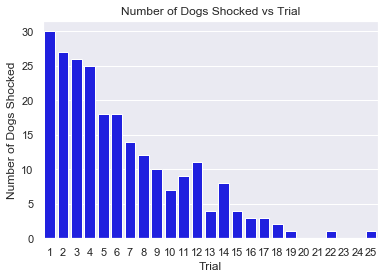

In [4]:
sns.set(style="darkgrid")
ax = sns.barplot(x="Trial", y="Number of Dogs Shocked", data=dogs_pd, color='blue')
ax.set_title('Number of Dogs Shocked vs Trial')

In [5]:
# average number of trials needed before dog avoids for first time
num_shocked_until_avoid = np.argmin(dog_data, axis=1)
num_shocked_mean = np.mean(num_shocked_until_avoid)
num_shocked_std = np.std(num_shocked_until_avoid)
print('mean: ', num_shocked_mean)
print('std: ', num_shocked_std)

mean:  4.5
std:  2.247220505424423


# Stop and Frisk

In [36]:
nypd_pd_2014 = pd.read_csv('./sqf-2014.csv',  
                 dtype={'year': int, 'pct':int, 'datestop':int, 
                        'crimsusp':str, 'arstmade':str, 'race':str})[['year', 'pct', 'datestop', 'crimsusp', 'arstmade', 'race']]
nypd_pd_2015 = pd.read_csv('./sqf-2015.csv',  
                 dtype={'year': int, 'pct':int, 'datestop':int, 
                        'crimsusp':str, 'arstmade':str, 'race':str})[['year', 'pct', 'datestop', 'crimsusp', 'arstmade', 'race']]
nypd_pd_2016 = pd.read_csv('./sqf-2016.csv',  
                 dtype={
                        'crimsusp':str, 'arstmade':str, 'race':str})[['year', 'pct', 'datestop', 'crimsusp', 'arstmade', 'race']]
nypd_pd_2016 = nypd_pd_2016.drop(12404)
nypd_pd_2016.year = nypd_pd_2016.year.astype(int)
nypd_pd_2016.pct = nypd_pd_2016.pct.astype(int)
nypd_pd_2016.datestop = nypd_pd_2016.datestop.astype(int)


C:\Users\maxpi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (10,83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\maxpi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,1,2,3,4,8,18,19,73,74,84,85,86,103,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
nypd_pd_2016 = nypd_pd_2016[nypd_pd_2016['datestop'] < 4000000] # only consider stops up to march
nypd_pd = pd.concat((nypd_pd_2015, nypd_pd_2016))

In [38]:
# restrict to weapons related crimes
# unsure of whether to include following line for 2014; is the number of arrests in the previous year categorized by crime type?
nypd_pd_2014 = nypd_pd_2014[nypd_pd_2014['crimsusp'].str.contains('CPW|DWEAPON|WEAP|FIREARM|KNIFE|GUN', regex=True)]
nypd_pd = nypd_pd[nypd_pd['crimsusp'].str.contains('CPW|DWEAPON|WEAP|FIREARM|KNIFE|GUN', regex=True)]

In [39]:
from collections import defaultdict

In [40]:
races = set(['W', 'B', 'Q']) # white, black, hispanic (Q)
# count n_ep 
n_ep = {} # ethnicity -> {precinct : int}
n_ep['W'] = defaultdict(int)
n_ep['B'] = defaultdict(int)
n_ep['Q'] = defaultdict(int)

for race, pct, arstmade in zip(nypd_pd_2014['race'], nypd_pd_2014['pct'], nypd_pd_2014['arstmade']):
    if race in races and arstmade == 'Y':
        n_ep[race][pct] += 1

In [41]:
# count y_ep 
y_ep = {} # ethnicity -> precinct : int
y_ep['W'] = defaultdict(int)
y_ep['B'] = defaultdict(int)
y_ep['Q'] = defaultdict(int)
for race, pct in zip(nypd_pd['race'], nypd_pd['pct']):
    if race in races:
        y_ep[race][pct] += 1

In [42]:
print(len(list(n_ep['W'].keys())))
print(len(list(n_ep['B'].keys())))
print(len(list(n_ep['Q'].keys())))

27
50
37


In [43]:
print(len(list(y_ep['W'].keys())))
print(len(list(y_ep['B'].keys())))
print(len(list(y_ep['Q'].keys())))

44
63
50


# Pre-Processing

In [44]:
import copy

In [45]:
# make sure that all sets have all precincts; if a precinct does not occur in n_ep, set it equal to 1e-6. Set it to 0 in y_ep 

n_ep_z = copy.deepcopy(n_ep)

# list of all precincts
all_dicts = list(n_ep.values()) + list(y_ep.values())
all_precincts = set()
for current_dict in all_dicts:
    for precinct in current_dict.keys():
        all_precincts.add(precinct)
all_precincts = list(all_precincts)

# handle missing precincts in n_ep_z
# this dictionary is used for models that directly 
# take the log of this value
for n_dict in n_ep.values():
    for precinct in all_precincts:
        if precinct not in n_dict:
            #n_dict[precinct] = 1e-6
            n_dict[precinct] = 1

# handle missing precincts in n_ep
for n_dict in n_ep_z.values():
    for precinct in all_precincts:
        if precinct not in n_dict:
            n_dict[precinct] = 0
            
# handle missing precincts in y_ep
for y_dict in y_ep.values():
    for precinct in all_precincts:
        if precinct not in y_dict:
            y_dict[precinct] = 0

In [46]:
# read-in precinct census data
eth_census = pd.read_csv('./NYC_precinct_census_2017.csv', delimiter=',')

# split precincts into each category 
# 0 = less than 10% black
# 1 = 10-40% black
# 2 = > 40% black
precinct_to_category = {}
for index, row in eth_census.iterrows():
    percent_black = row['Sum_Black']/row['Sum_Total_']
    current_precinct = row['Precinct']
    if percent_black < 0.1:
        precinct_to_category[current_precinct] = 0
    elif percent_black <= 0.4:
        precinct_to_category[current_precinct] = 1
    else:
        precinct_to_category[current_precinct] = 2

In [47]:
eth_census

,Precinct,Cnt_Precin,Sum_Total_,Sum_White,Sum_Black,Sum_Hispan
0,0,9107,11241470,8326912,957142,1235229
1,1,34,73428,51658,1802,4956
2,5,35,52118,11221,2682,5898
3,6,48,61397,49538,1302,3524
4,7,37,54851,13334,3960,18327
...,...,...,...,...,...,...
73,115,104,165906,17738,8688,107392
74,120,86,111562,43985,24541,31045
75,121,76,123096,61488,14774,28120
76,122,93,137849,102714,4439,17651


In [48]:
# export each e set for each category

# in the case of y_ep, occurrences is the number of stops 
# in the case of n_ep, occurrences is the number of arrests
def precinct_dataframe(list_data):
    return pd.DataFrame(list_data, columns = ['Precinct', 'Ethnic_Comp_Cat', 'Race', 'Race_Int', 'Eth_Pop_In_Precinct', 'Occurrences']) 

def get_eth_pop(precinct, race):
    race_col = ''
    if race == 'W':
        race_col = 'Sum_White'
    elif race == 'B':
        race_col = 'Sum_Black'
    else:
        race_col = 'Sum_Hispan'
        
    return int(eth_census[eth_census['Precinct']==precinct][race_col])
    
def extract_3_cats(ep):
    list_data = []
    races = ['W', 'B', 'Q']
    race_int = {'W':1, 'B':2, 'Q':3}
    
    for precinct in all_precincts:
        next_added = [[precinct, precinct_to_category[precinct], race, race_int[race], get_eth_pop(precinct, race), ep[race][precinct]] for race in races]
        list_data.extend(next_added)
    
    return precinct_dataframe(list_data)
    
n_ep_df = extract_3_cats(n_ep)
n_ep_z_df = extract_3_cats(n_ep_z)
y_ep_df = extract_3_cats(y_ep)

In [49]:
y_ep_df.to_csv('./20152016_stops.csv', index=False)
n_ep_df.to_csv('./2014_arrests_ones.csv', index=False)
n_ep_z_df.to_csv('./2014_arrests_zeros.csv', index=False)

In [34]:
y_ep_df.to_csv('./20152016_stops_all_crimes.csv', index=False)
n_ep_df.to_csv('./2014_arrests_ones_all_crimes.csv', index=False)
n_ep_z_df.to_csv('./2014_arrests_zeros_all_crimes.csv', index=False)

In [17]:
n_ep_df

,Precinct,Ethnic_Comp_Cat,Race,Race_Int,Eth_Pop_In_Precinct,Occurrences
0,1,0,W,1,51658,1
1,1,0,B,2,1802,1
2,1,0,Q,3,4956,1
3,5,0,W,1,11221,1
4,5,0,B,2,2682,1
...,...,...,...,...,...,...
211,121,1,B,2,14774,4
212,121,1,Q,3,28120,1
213,122,0,W,1,102714,2
214,122,0,B,2,4439,1


# Exploratory Analysis 

In [37]:
def valsList(a_dict):
    return list(a_dict.values())

In [38]:
def calcMeanStd(ep):
    means = (np.mean(valsList(ep['W'])), np.mean(valsList(ep['B'])), np.mean(valsList(ep['Q'])))
    stds = (np.std(valsList(ep['W'])), np.std(valsList(ep['B'])), np.std(valsList(ep['Q'])))
    return means, stds

In [39]:
n_ep_means, n_ep_stds = calcMeanStd(n_ep)
y_ep_means, y_ep_stds = calcMeanStd(y_ep)

In [40]:
print(n_ep_means)
print(n_ep_stds)
print(y_ep_means)
print(y_ep_stds)

(9.207792376623376, 44.76623376623377, 22.831168883116888)
(13.638503119521745, 49.459913219551986, 32.78279660743759)
(1.844155844155844, 30.675324675324674, 9.454545454545455)
(3.471834482951527, 52.42469963088097, 18.709359734542105)


In [13]:
print(len(n_ep['W']))
print(len(n_ep['B']))
print(len(n_ep['Q']))

27
50
37


In [14]:
print(len(y_ep['W']))
print(len(y_ep['B']))
print(len(y_ep['Q']))

44
63
50


In [15]:
y_w_vals = valsList(y_ep['W'])
y_b_vals = valsList(y_ep['B'])
y_q_vals = valsList(y_ep['Q'])
vals = y_w_vals + y_b_vals + y_q_vals
labels = ['White'] * len(y_w_vals) + ['Black'] * len(y_b_vals) + ['Hispanic'] * len(y_q_vals)

In [16]:
general_stops_df = pd.DataFrame(list(zip(vals, labels)), columns=['Number of Stops', 'Ethnic Group'])

Text(0.5,1,'Number of Stops vs Ethnic Group')

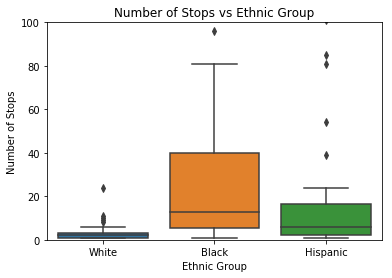

In [17]:
ax = sns.boxplot(x="Ethnic Group", y="Number of Stops", data=general_stops_df)
ax.set_ylim([0, 100]) 
ax.set_title('Number of Stops vs Ethnic Group')

In [18]:
y_w_precincts = set(list(y_ep['W'].keys()))
y_b_precincts = set(list(y_ep['B'].keys()))
y_q_precincts = set(list(y_ep['Q'].keys()))
y_q_precincts.intersection(y_w_precincts.intersection(y_b_precincts))

{5,
 9,
 23,
 24,
 25,
 30,
 32,
 40,
 41,
 44,
 46,
 47,
 48,
 49,
 50,
 60,
 61,
 63,
 70,
 75,
 76,
 79,
 84,
 88,
 100,
 102,
 103,
 104,
 107,
 109,
 110,
 115,
 120,
 122}

In [19]:
print(y_ep['W'][5])
print(y_ep['B'][5])
print(y_ep['Q'][5])

8
13
5


In [20]:
def makePrecinctPlots(precincts, ep):
    f, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,6))
    
    for i, precinct in enumerate(precincts):
        w = ep['W'][precinct]
        b = ep['B'][precinct]
        q = ep['Q'][precinct]
        total = sum([w,b,q])
        props = [w/total, b/total, q/total]
        labels = ['White', 'Black', 'Hispanic']
        df = pd.DataFrame(list(zip(props, labels)), columns=['Proportion of Stops', 'Ethnic Group'])
        
        ax = sns.barplot(y="Proportion of Stops", x= "Ethnic Group", data=df,  orient='v' , ax=axes[i])
        ax.set(xlabel='', ylabel='')
        ax.set_title('Precinct {0}'.format(precinct))
        
    f.text(0.5, 0.04, 'Ethnic Group', ha='center', va='center', fontsize=14)
    f.text(0.08, 0.5, 'Fraction of Stops in Precinct', ha='center', va='center', rotation='vertical', fontsize=14)
    f.text(0.5, 0.96, 'Fraction of Stops in Precinct vs Ethnic Group', ha='center', va='center', fontsize=14)
    
    return f, axes

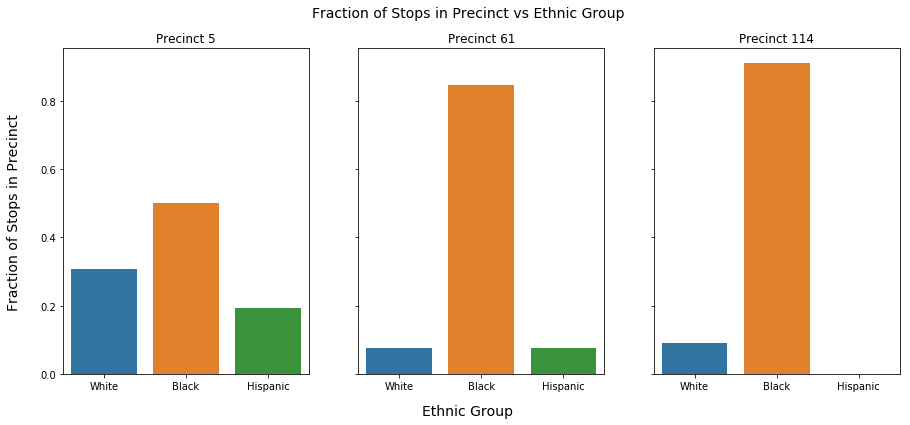

In [21]:
f, axes = makePrecinctPlots([5, 61, 114], y_ep)

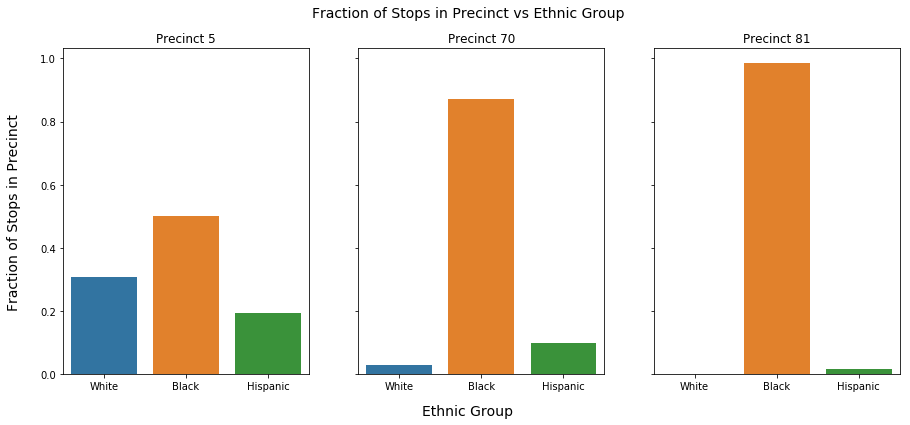

In [22]:
# <10, 10-40, >40
f, axes = makePrecinctPlots([5, 70, 81], y_ep)

In [30]:
y_ep['W'][69]

0

C:\Users\maxpi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


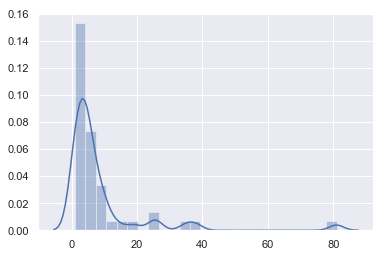

In [26]:
sns.distplot(list(y_ep['W'].values()))

C:\Users\maxpi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


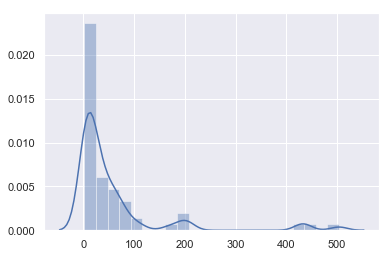

In [27]:
sns.distplot(list(y_ep['B'].values()))

C:\Users\maxpi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


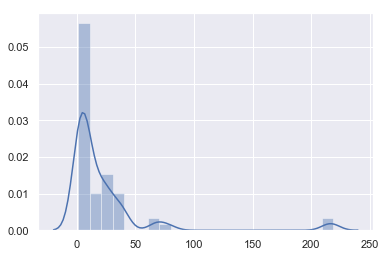

In [249]:
sns.distplot(list(y_ep['Q'].values()))

In [259]:
def makeHists(ep):
    f, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6,15))
    w_vals = []
    b_vals = []
    q_vals = []
    
    y_w_precincts = set(list(y_ep['W'].keys()))
    y_b_precincts = set(list(y_ep['B'].keys()))
    y_q_precincts = set(list(y_ep['Q'].keys()))
    common = y_q_precincts.intersection(y_w_precincts.intersection(y_b_precincts))
    
    for precinct in common:
        w = ep['W'][precinct]
        b = ep['B'][precinct]
        q = ep['Q'][precinct]
        total = sum([w,b,q])
        w_vals.append(w/total)
        b_vals.append(b/total)
        q_vals.append(q/total)
    
    ax = sns.distplot(w_vals, ax=axes[0], bins=5)
    ax.set_xlim([0,1])
    ax = sns.distplot(b_vals, ax=axes[1], bins=5)
    ax = sns.distplot(q_vals, ax=axes[2], bins=5)
        
    #f.text(0.5, 0.04, 'Ethnic Group', ha='center', va='center', fontsize=14)
    #f.text(0.08, 0.5, 'Fraction of Stops in Precinct', ha='center', va='center', rotation='vertical', fontsize=14)
    #f.text(0.5, 0.96, 'Fraction of Stops in Precinct vs Ethnic Group', ha='center', va='center', fontsize=14)
    
    return f, axes

C:\Users\maxpi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(<Figure size 432x1080 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002877140F4A8>,
       dtype=object))

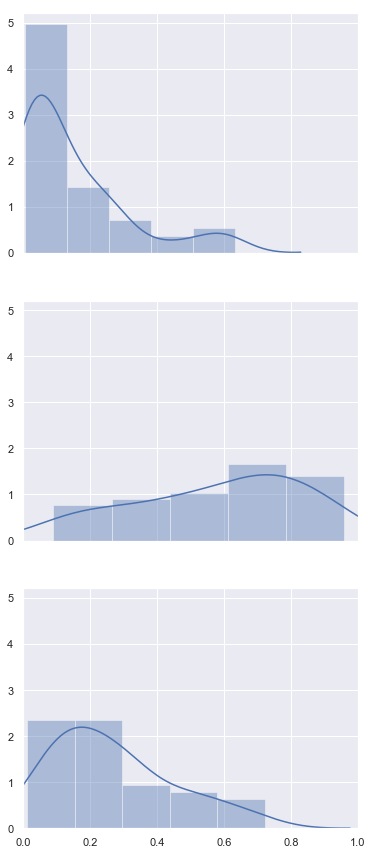

In [260]:
makeHists(y_ep)